In [7]:
"""Produces several plots based upon the data computed in main.py"""
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def load_previous(name):
    with open(name + '.pickle', 'rb') as f:
        previous = pickle.load(f)
        pass
    return previous


def extract_data(results, nb_arms, lengths):
    data = np.zeros(lengths + [nb_arms+2])
    settling_times = np.zeros(lengths)
    for v, r, t in results:
        data[v] = r
        settling_times[v] = t
        pass
    return data, settling_times


def theta_comp(data):
    thetas = 1 - data[..., 0]
    if np.any(thetas[..., 0] > 1e-5):
        print("Choose a lower nr_range lower bound!")
    if np.any(thetas[..., -1] < 0.9):
        print("Choose a higher nr_range upper bound!")
    return thetas


def alpha_comp(thetas, spacing):
    return np.log(thetas[..., 1:] / thetas[..., :-1]) / spacing


def max_alpha_comp(alphas):
    return alphas.max(axis=-1), alphas.argmax(axis=-1)

In [9]:
def find_nearest(params, iv):
    i, j = [np.argmin(np.abs(iv[i] - params[i])) for i in range(2)]
    return (i, j), (iv[0][i], iv[1][j])


def relative_change(data, nb_arms, labels, nrs, pm):
    (i, j), (k_sol, k_sur) = pm
    plt.figure()
    for arm in range(nb_arms+1):
        plt.semilogx(nrs, data[i, j, :, arm], c=plt.colormaps["winter"](arm/nb_arms))
        pass
    plt.semilogx(nrs, data[i, j, :, -1], c='black')
    plt.title(f"k_sol: {k_sol}, k_sur: {k_sur}")
    plt.xlabel(r"$n_{R}$ (number of receptors / number of stars)")
    plt.ylabel("fraction of possible")
    plt.legend(labels)
    pass


def theta(thetas, nrs, pm):
    (i, j), (k_sol, k_sur) = pm
    plt.figure()
    plt.semilogx(nrs, thetas[i, j, :])
    plt.title(f"k_sol: {k_sol}, k_sur: {k_sur}")
    plt.xlabel(r"$n_{R}$ (number of receptors / number of stars)")
    plt.ylabel(r"$\theta$")
    pass


def alpha(alphas, nrs, pm):
    (i, j), (k_sol, k_sur) = pm

    plt.figure()
    plt.semilogx(nrs[1:], alphas[i, j, :])
    plt.title(f"k_sol: {k_sol}, k_sur: {k_sur}")
    plt.xlabel(r"$n_{R}$ (number of receptors / number of stars)")
    plt.ylabel(r"$\alpha$")
    pass


def max_alpha(m_alphas, k_sol, k_sur, lengths, nb_arms, color_max):   
    plt.figure()
    plt.imshow(m_alphas, cmap='RdYlGn', vmin=1, vmax=color_max)
    plt.colorbar()
    # plt.title(f"{nb_arms} arms, " + r"$\alpha_{max}$")
    plt.title(f"{nb_arms} arms")
    plt.xlabel(r"$\log k_{on, sur}$")
    plt.ylabel(r"$\log k_{on, sol}$")
    plt.xticks(np.arange(lengths[1]), np.log10(k_sur))
    plt.yticks(np.arange(lengths[0]), np.log10(k_sol))
    pass


def theta_max_alpha(thetas, i_m_alphas, k_sol, k_sur, lengths, nb_arms):
    res = np.zeros((lengths[0], lengths[1]))
    for i in range(lengths[0]):
        for j in range(lengths[1]):
            res[i, j] = np.log10(thetas[i, j, i_m_alphas[i, j]])
            pass
        pass
    
    plt.figure()
    plt.imshow(res, cmap='RdYlGn', vmax=0)
    plt.colorbar()
    plt.title(f"{nb_arms} arms, " + r"$\log \theta_{\alpha_{max}}$")
    plt.xlabel(r"$\log k_{on, sur}$")
    plt.ylabel(r"$\log k_{on, sol}$")
    plt.xticks(np.arange(lengths[1]), np.log10(k_sur))
    plt.yticks(np.arange(lengths[0]), np.log10(k_sol))
    pass


def settling_time(st, nrs, pm):
    (i, j), (k_sol, k_sur) = pm
    plt.figure()
    plt.loglog(nrs, st[i, j])
    plt.semilogx(nrs, st[i, j])
    plt.title(f"k_sol: {k_sol}, k_sur: {k_sur}")
    plt.xlabel(r"$n_{R}$ (number of receptors / number of stars)")
    plt.ylabel(r"Settling time [s]")
    pass

def max_settling_time(nb_arms, st, k_sol, k_sur, lengths):
    plt.figure()
    plt.imshow(np.log10(st.max(axis=-1)), cmap='coolwarm', vmin=0, vmax=10)
    plt.colorbar()
    plt.title(f"{nb_arms} arms, "+  r"$\log$" +  "(maximum settling time)")
    plt.xlabel(r"$\log k_{on, sur}$")
    plt.ylabel(r"$\log k_{on, sol}$")
    plt.xticks(np.arange(lengths[1]), np.log10(k_sur))
    plt.yticks(np.arange(lengths[0]), np.log10(k_sol))
    pass

In [10]:
def plots(pms, k_sol, k_sur):
    name, color_max = pms.values()
    results, iv = load_previous(name)
    nb_arms, cst, (k_sol_range, k_sur_range, nrs) = iv
    spacing = np.log(nrs[1]/nrs[0])
    lengths = [len(rg) for rg in iv[2]]
    
    data, st = extract_data(results, nb_arms, lengths)
    thetas = theta_comp(data)
    alphas = alpha_comp(thetas, spacing)
    m_alphas, i_m_alphas = max_alpha_comp(alphas)
    
    pm = find_nearest((k_sol, k_sur), iv[2])
    labels = [f"n{i}" for i in range(nb_arms+1)] + ['rec']
    
    max_alpha(m_alphas, k_sol_range, k_sur_range, lengths, nb_arms, color_max)
    theta_max_alpha(thetas, i_m_alphas, k_sol_range, k_sur_range, lengths, nb_arms)
    relative_change(data, nb_arms, labels, nrs, pm)
    theta(thetas, nrs, pm)
    alpha(alphas, nrs, pm)
    if cst:
        settling_time(st, nrs, pm)
        max_settling_time(nb_arms, st, k_sol_range, k_sur_range, lengths)
    pass

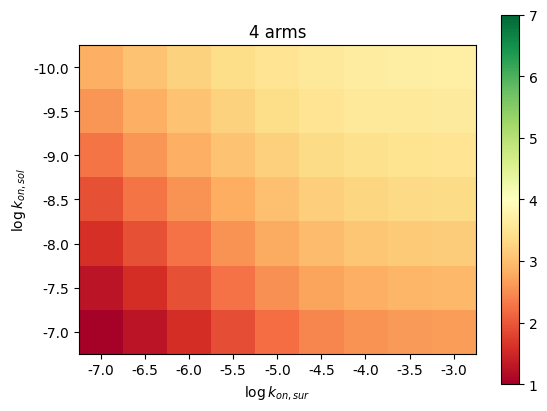

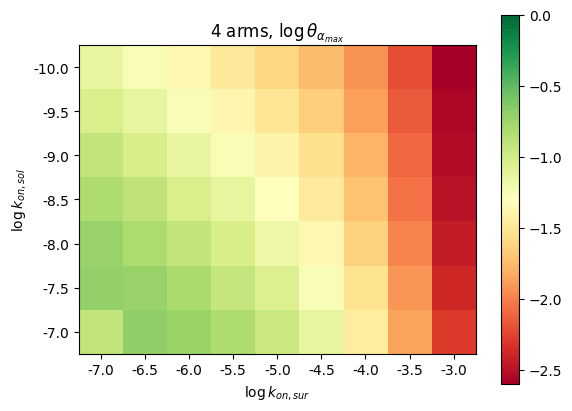

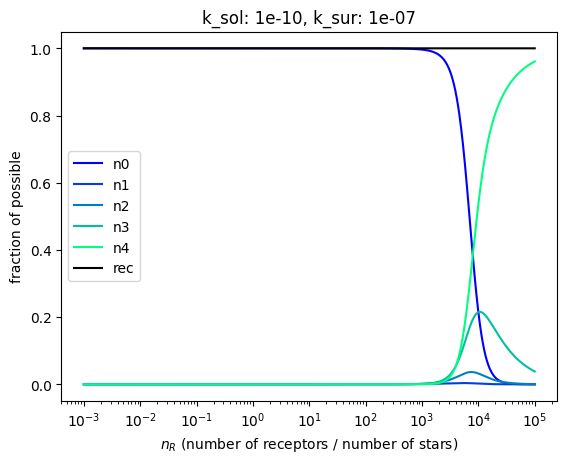

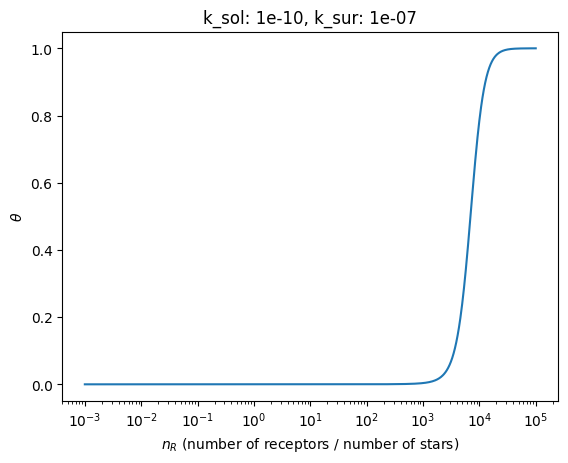

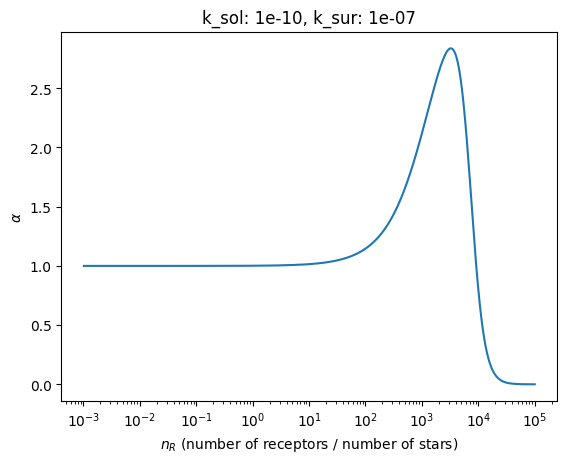

In [15]:
parameters = {"name": "k4", "color_max": 7}
plots(parameters, k_sol=1e-10, k_sur=1e-7)  # specific k_sol & k_sur for relevant plots